In [111]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_model_name(path):
    if "gpt-3.5" in path:
        return "GPT-3.5"
    if "gpt-4" in path:
        return "GPT-4"
    if "command" in path:
        return "Command R+"
    if "llama" in path:
        return "LLama3-70B"

def get_ds_name(path):
    if "ap" in path:
        return "PR"
    if "ec" in path:
        return "EC"
    if "prism" in path:
        return "PRISM"
    if "opinionqa" in path:
        return "OpinionQA"

def draw_certainty_plot(jsonl_path):
    file_name = jsonl_path.split('/')[-1]
    output_path = os.path.join('figures', file_name.replace('.jsonl', '_certainty_plot.pdf'))
    model_name = get_model_name(jsonl_path)
    ds_name = get_ds_name(jsonl_path)

    df = pd.read_json(jsonl_path, lines=True)
    df = df[(df['answer'] == "A") | (df['answer'] == "B")]

    acc = df['acc'].mean().__round__(3)

    try:
        df['certainty'] = df['certainty'].apply(lambda x: int(x) if x != "NA" else 0)
        df['certainty'] = df['certainty'].apply(lambda x: x if type(x) == str else int(x//10))
        df['certainty'] = df['certainty'].apply(lambda x: 4 if x < 4 else x)
        df['certainty'] = df['certainty'].apply(lambda x: 9 if x > 9 else x)
    except Exception as e:
        print(f'Error dividing certainty: {e}')
    
    threshold = 8
    high_conf_acc = df[df['certainty'] >= threshold]['acc'].mean().__round__(3)
    low_conf_acc = df[df['certainty'] < threshold]['acc'].mean().__round__(3)
    high_conf_count = len(df[df['certainty'] >= threshold])
    low_conf_count = len(df[df['certainty'] < threshold])
    
    if math.isnan(high_conf_acc):
        high_conf_acc = 0
    if math.isnan(low_conf_acc):
        low_conf_acc = 0

    grouped = df.groupby('certainty')['acc'].agg(
        Total_Responses='count',
        Correct_Responses=lambda x: x.sum(),
        Accuracy='mean'
    ).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 7))
    width = 0.8
    bars1 = ax.bar(grouped['certainty'], grouped['Correct_Responses'], width, label='Correct Answer', color='#4C72B0')
    bars2 = ax.bar(grouped['certainty'], grouped['Total_Responses'] - grouped['Correct_Responses'], width, bottom=grouped['Correct_Responses'], label='Wrong Answer', color='#DD8452')

    ax.set_xlabel('Certainty', fontsize=28)
    ax.set_ylabel('Count', fontsize=28)
    # ax.set_title(f'Overall Accuracy: {acc} \n High Certainty Accuracy: {high_conf_acc}  Low Certainty Accuracy: {low_conf_acc}', fontsize=26)
    ax.set_title(f'ACC: {acc}  High Certainty ACC: {high_conf_acc}  Low Certainty ACC: {low_conf_acc}', fontsize=20)
    ax.set_xticks(np.arange(4, 10))
    ax.set_xticklabels(np.arange(40, 100, 10), fontsize=26)
    ax.set_yticklabels(ax.get_yticks(), fontsize=26)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
    ax.set_ylim(0, grouped['Total_Responses'].max() * 1.1)
    ax.set_xlim(3.5, 9.5)
    if ds_name == "OpinionQA" and model_name == "LLama3-70B":
        ax.legend(loc='upper left', bbox_to_anchor=(0, 0.95), fontsize=22, framealpha=0.5)
    else:
        ax.legend(fontsize=22)

    plt.text(0.5, 1.15, f"{model_name} on {ds_name}", ha='center', va='center', transform=ax.transAxes, fontsize=30, bbox=dict(facecolor='white', alpha=0.6))

    # plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    for bar1, bar2, bar_acc in zip(bars1, bars2, grouped['Accuracy']):
        yval = bar1.get_height() + bar2.get_height() 
        ax.text(bar1.get_x() + bar1.get_width() / 2, yval, f'{bar_acc:.2f}', ha='center', va='bottom', fontsize=26, color='black')
    
    print(output_path)
    print(f"Overall acc: {acc}, {(int(high_conf_count * high_conf_acc) + int(low_conf_count * low_conf_acc)) / (high_conf_count + low_conf_count)}")
    print(f"Total number of high confidence responses: {high_conf_count}, total correct: {int(high_conf_count * high_conf_acc)} acc: {high_conf_acc}")
    print(f"Total number of low confidence responses: {low_conf_count}, total correct: {int(low_conf_count * low_conf_acc)} acc: {low_conf_acc}")
    
    plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
    # plt.show()


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_key_features_command-r-plus_certainty_plot.pdf
Overall acc: 0.678, 0.6763236763236763
Total number of high confidence responses: 174, total correct: 128 acc: 0.741
Total number of low confidence responses: 827, total correct: 549 acc: 0.665


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/opinionqa_all_features_key_features_gpt-4o_jun_11_certainty_plot.pdf
Overall acc: 0.612, 0.6119402985074627
Total number of high confidence responses: 239, total correct: 199 acc: 0.833
Total number of low confidence responses: 2776, total correct: 1646 acc: 0.593


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ec_all_features_command-r-plus_certainty_plot.pdf
Overall acc: 0.541, 0.5392156862745098
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 510, total correct: 275 acc: 0.541


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ap_all_features_all_features_command-r-plus_jun5_certainty_plot.pdf
Overall acc: 0.964, 0.9619047619047619
Total number of high confidence responses: 361, total correct: 345 acc: 0.958
Total number of low confidence responses: 164, total correct: 160 acc: 0.976


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_with_tie_all_features_command-r-plus_certainty_plot.pdf
Overall acc: 0.66, 0.6590909090909091
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 792, total correct: 522 acc: 0.66


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ec_all_features_gpt-3.5-turbo_certainty_plot.pdf
Overall acc: 0.529, 0.5269461077844312
Total number of high confidence responses: 472, total correct: 250 acc: 0.53
Total number of low confidence responses: 29, total correct: 14 acc: 0.517


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/opinionqa_all_features_all_features_meta-llama_Meta-Llama-3-70B-Instruct_jun_11_certainty_plot.pdf
Overall acc: 0.629, 0.6294078509647372
Total number of high confidence responses: 1366, total correct: 964 acc: 0.706
Total number of low confidence responses: 1640, total correct: 928 acc: 0.566


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_with_tie_all_features_meta-llama_Meta-Llama-3-70B-Instruct_jun5_certainty_plot.pdf
Overall acc: 0.713, 0.7086956521739131
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 230, total correct: 163 acc: 0.713


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ec_all_features_with_tie_all_features_gpt-3.5-turbo_certainty_plot.pdf
Overall acc: 0.384, 0.3838771593090211
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 521, total correct: 200 acc: 0.384


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ap_all_features_all_features_meta-llama_Meta-Llama-3-70B-Instruct_certainty_plot.pdf
Overall acc: 0.949, 0.9466666666666667
Total number of high confidence responses: 520, total correct: 492 acc: 0.948
Total number of low confidence responses: 5, total correct: 5 acc: 1.0


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_command-r-plus_certainty_plot.pdf
Overall acc: 0.72, 0.7192807192807192
Total number of high confidence responses: 149, total correct: 133 acc: 0.893
Total number of low confidence responses: 852, total correct: 587 acc: 0.69


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/opinionqa_all_features_all_features_command-r-plus_jun_11_certainty_plot.pdf
Overall acc: 0.616, 0.6162520729684908
Total number of high confidence responses: 2, total correct: 2 acc: 1.0
Total number of low confidence responses: 3013, total correct: 1856 acc: 0.616


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_with_tie_all_features_gpt-4o_certainty_plot.pdf
Overall acc: 0.723, 0.7220779220779221
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 770, total correct: 556 acc: 0.723


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/opinionqa_all_features_key_features_command-r-plus_jun_11_certainty_plot.pdf
Overall acc: 0.612, 0.6119402985074627
Total number of high confidence responses: 2, total correct: 2 acc: 1.0
Total number of low confidence responses: 3013, total correct: 1843 acc: 0.612


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)
/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ec_all_features_with_tie_all_features_meta-llama_Meta-Llama-3-70B-Instruct_certainty_plot.pdf
Overall acc: 0.388, 0.38653846153846155
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 520, total correct: 201 acc: 0.388
figures/ec_all_features_with_tie_all_features_gpt-4o_certainty_plot.pdf
Overall acc: 0.425, 0.4235294117647059
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 510, total correct: 216 acc: 0.425


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ec_all_features_all_features_meta-llama_Meta-Llama-3-70B-Instruct_certainty_plot.pdf
Overall acc: 0.507, 0.5029469548133595
Total number of high confidence responses: 478, total correct: 240 acc: 0.504
Total number of low confidence responses: 31, total correct: 16 acc: 0.548


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ec_all_features_with_tie_all_features_command-r-plus_certainty_plot.pdf
Overall acc: 0.437, 0.43529411764705883
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 510, total correct: 222 acc: 0.437


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ap_all_features_all_features_gpt-4o_jun5_certainty_plot.pdf
Overall acc: 0.946, 0.9445506692160612
Total number of high confidence responses: 243, total correct: 228 acc: 0.942
Total number of low confidence responses: 280, total correct: 266 acc: 0.95


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_all_features_meta-llama_Meta-Llama-3-70B-Instruct_jun5_certainty_plot.pdf
Overall acc: 0.722, 0.7214428857715431
Total number of high confidence responses: 758, total correct: 570 acc: 0.753
Total number of low confidence responses: 240, total correct: 150 acc: 0.625


/tmp/ipykernel_237589/1315858049.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 7))
/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ec_no_persona_all_features_command-r-plus_certainty_plot.pdf
Overall acc: 0.498, 0.49607843137254903
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 510, total correct: 253 acc: 0.498


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/opinionqa_all_features_least_imp_feature_command-r-plus_jun_11_certainty_plot.pdf
Overall acc: 0.546, 0.5456053067993366
Total number of high confidence responses: 1, total correct: 0 acc: 0.0
Total number of low confidence responses: 3014, total correct: 1645 acc: 0.546


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ec_all_features_gpt-4o_certainty_plot.pdf
Overall acc: 0.591, 0.5909090909090909
Total number of high confidence responses: 4, total correct: 4 acc: 1.0
Total number of low confidence responses: 502, total correct: 295 acc: 0.588


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_gpt-3.5-turbo_certainty_plot.pdf
Overall acc: 0.656, 0.655
Total number of high confidence responses: 773, total correct: 520 acc: 0.673
Total number of low confidence responses: 227, total correct: 135 acc: 0.599


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_with_tie_all_features_gpt-3.5-turbo_certainty_plot.pdf
Overall acc: 0.536, 0.5352112676056338
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 994, total correct: 532 acc: 0.536


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_key_features_gpt-4o_jun5_certainty_plot.pdf
Overall acc: 0.726, 0.7241379310344828
Total number of high confidence responses: 87, total correct: 78 acc: 0.908
Total number of low confidence responses: 551, total correct: 384 acc: 0.697


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/ap_all_features_all_features_gpt-3.5-turbo_certainty_plot.pdf
Overall acc: 0.755, 0.751434034416826
Total number of high confidence responses: 480, total correct: 365 acc: 0.762
Total number of low confidence responses: 43, total correct: 28 acc: 0.674


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_no_persona_command-r-plus_new_certainty_plot.pdf
Overall acc: 0.526, 0.5253549695740365
Total number of high confidence responses: 0, total correct: 0 acc: 0
Total number of low confidence responses: 986, total correct: 518 acc: 0.526


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_key_features_gpt-4o_certainty_plot.pdf
Overall acc: 0.707, 0.7051671732522796
Total number of high confidence responses: 114, total correct: 103 acc: 0.912
Total number of low confidence responses: 873, total correct: 593 acc: 0.68


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/opinionqa_all_features_least_imp_feature_gpt-4o_jun_11_certainty_plot.pdf
Overall acc: 0.588, 0.5880597014925373
Total number of high confidence responses: 10, total correct: 4 acc: 0.4
Total number of low confidence responses: 3005, total correct: 1769 acc: 0.589


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_gpt-4o_certainty_plot.pdf
Overall acc: 0.728, 0.7265388496468214
Total number of high confidence responses: 120, total correct: 108 acc: 0.908
Total number of low confidence responses: 871, total correct: 612 acc: 0.703


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/opinionqa_all_features_all_features_gpt-3.5-turbo_jun_11_certainty_plot.pdf
Overall acc: 0.569, 0.5678475935828877
Total number of high confidence responses: 2890, total correct: 1641 acc: 0.568
Total number of low confidence responses: 102, total correct: 58 acc: 0.578


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_least_imp_feature_command-r-plus_certainty_plot.pdf
Overall acc: 0.673, 0.6713286713286714
Total number of high confidence responses: 214, total correct: 166 acc: 0.78
Total number of low confidence responses: 787, total correct: 506 acc: 0.644


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/opinionqa_all_features_all_features_gpt-4o_jun_11_certainty_plot.pdf
Overall acc: 0.634, 0.6338308457711442
Total number of high confidence responses: 480, total correct: 385 acc: 0.804
Total number of low confidence responses: 2535, total correct: 1526 acc: 0.602


/tmp/ipykernel_237589/1315858049.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=26)


figures/prism_all_features_least_imp_feature_gpt-4o_certainty_plot.pdf
Overall acc: 0.73, 0.727547931382442
Total number of high confidence responses: 92, total correct: 80 acc: 0.88
Total number of low confidence responses: 899, total correct: 641 acc: 0.714


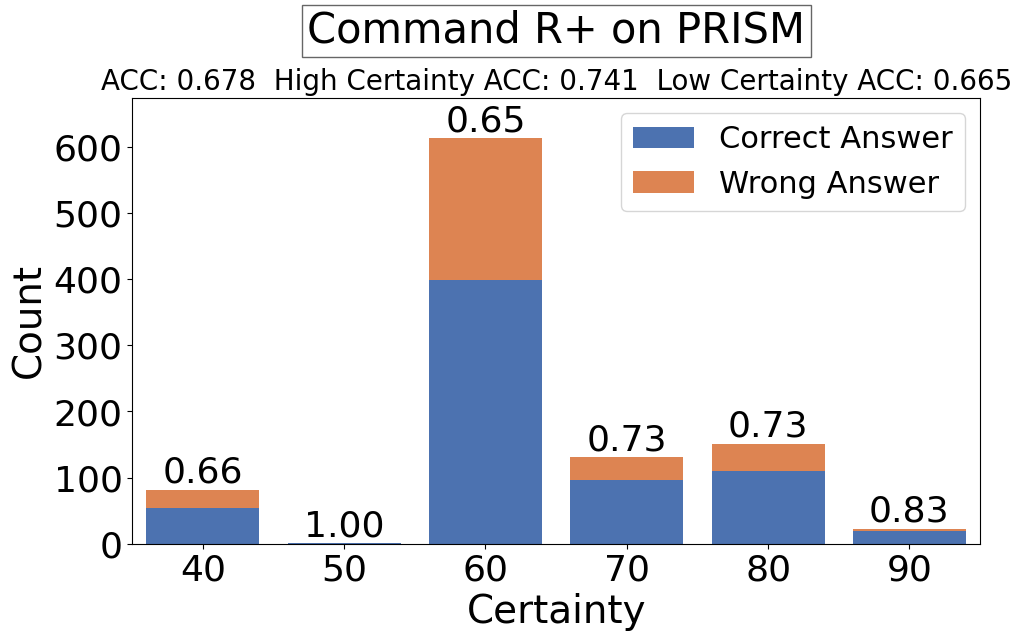

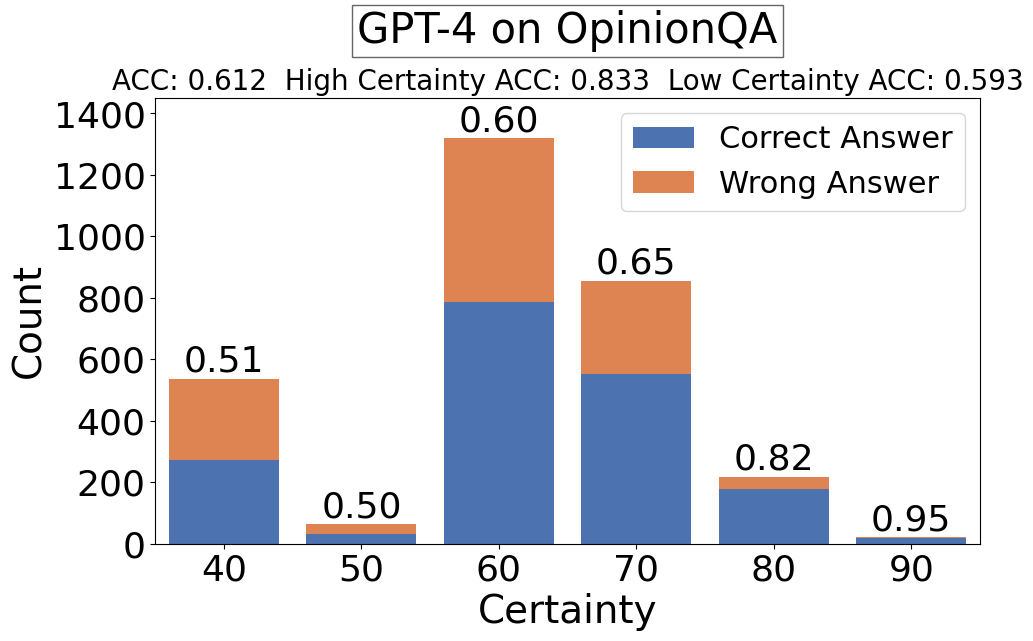

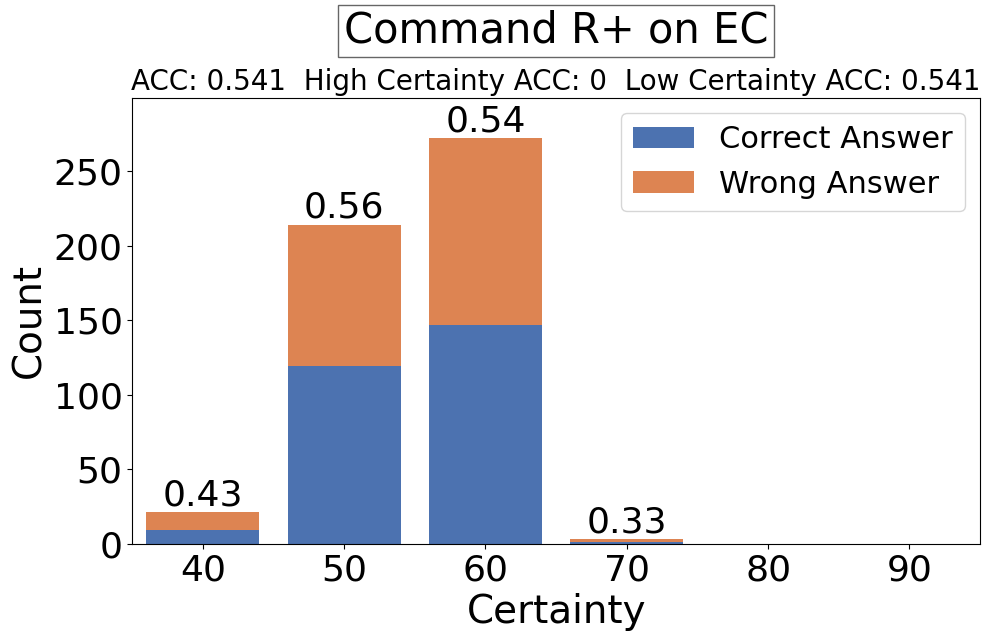

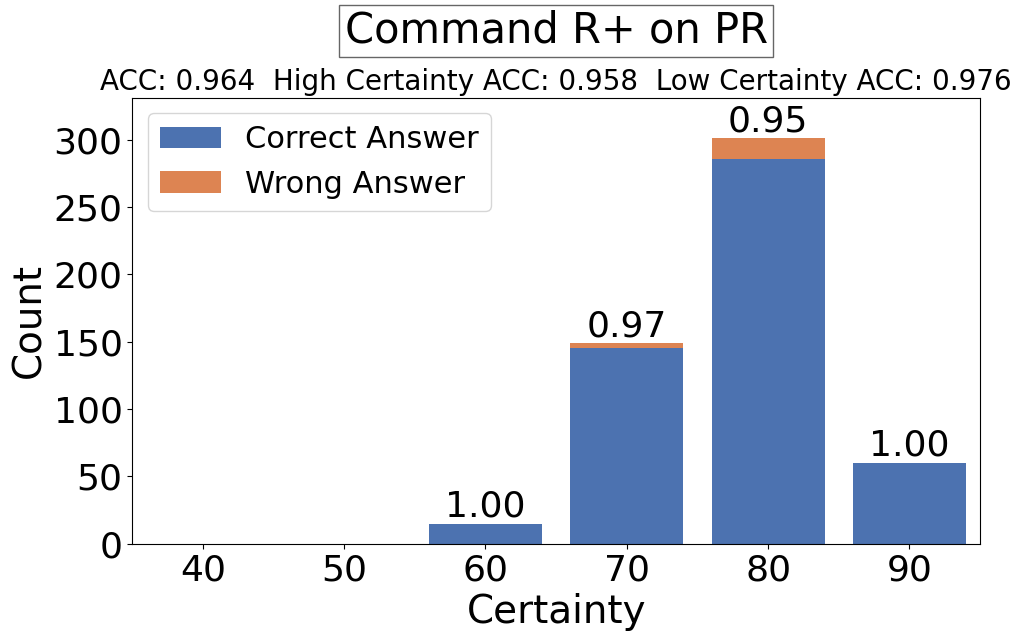

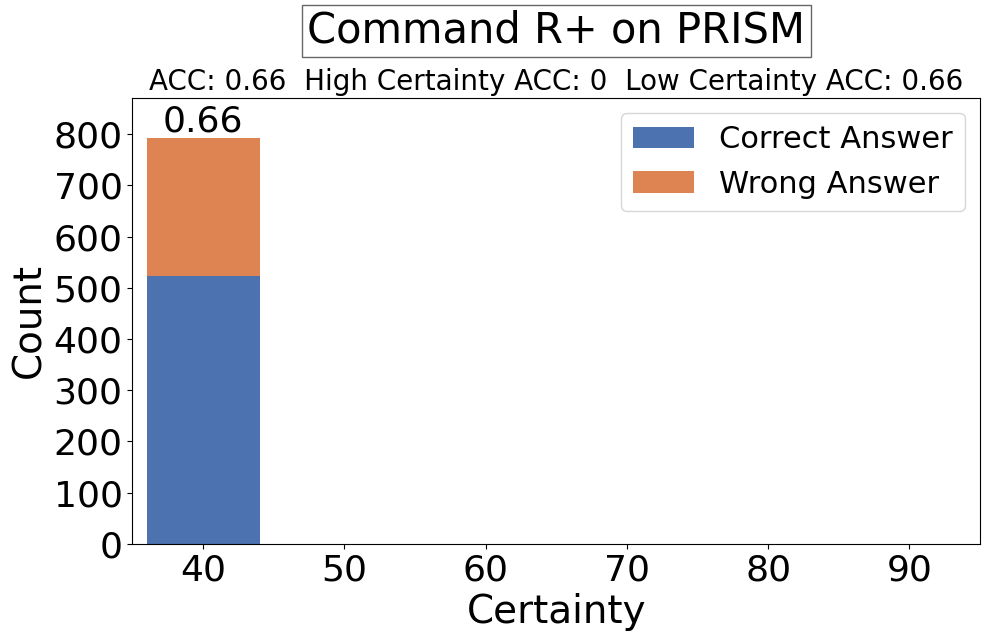

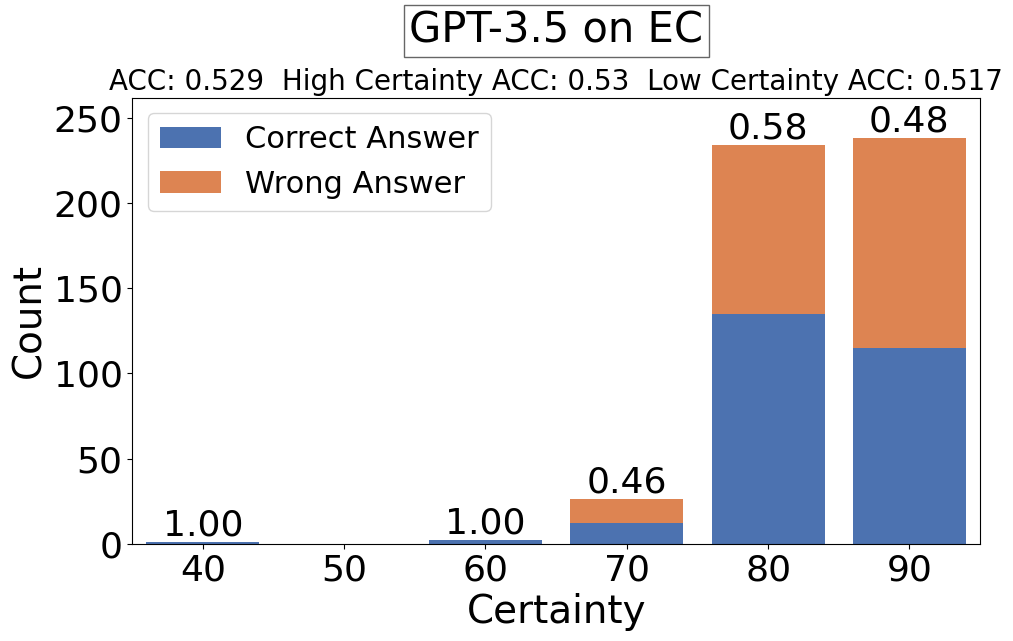

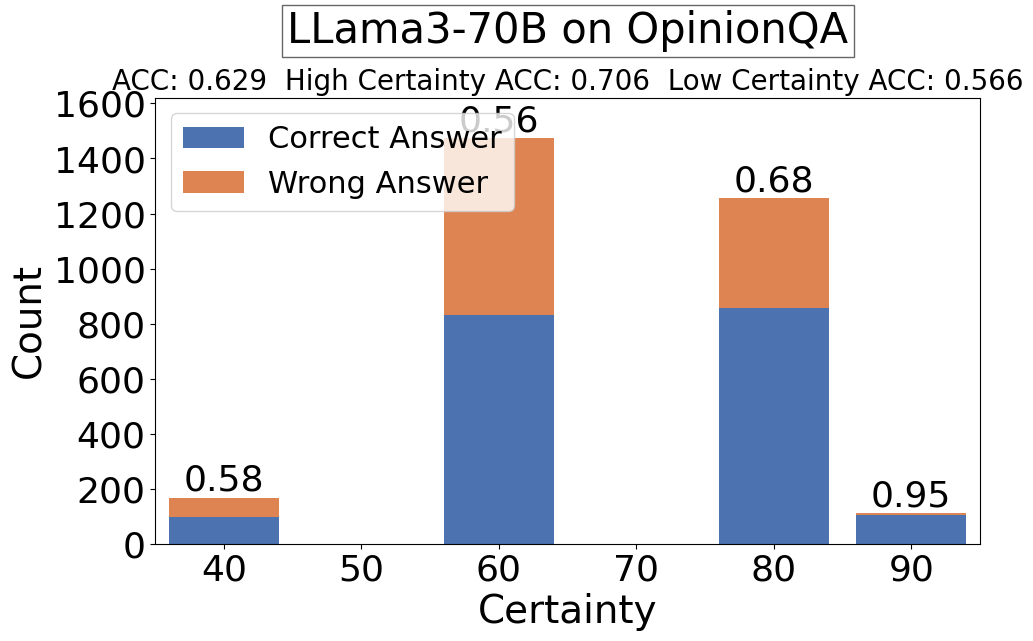

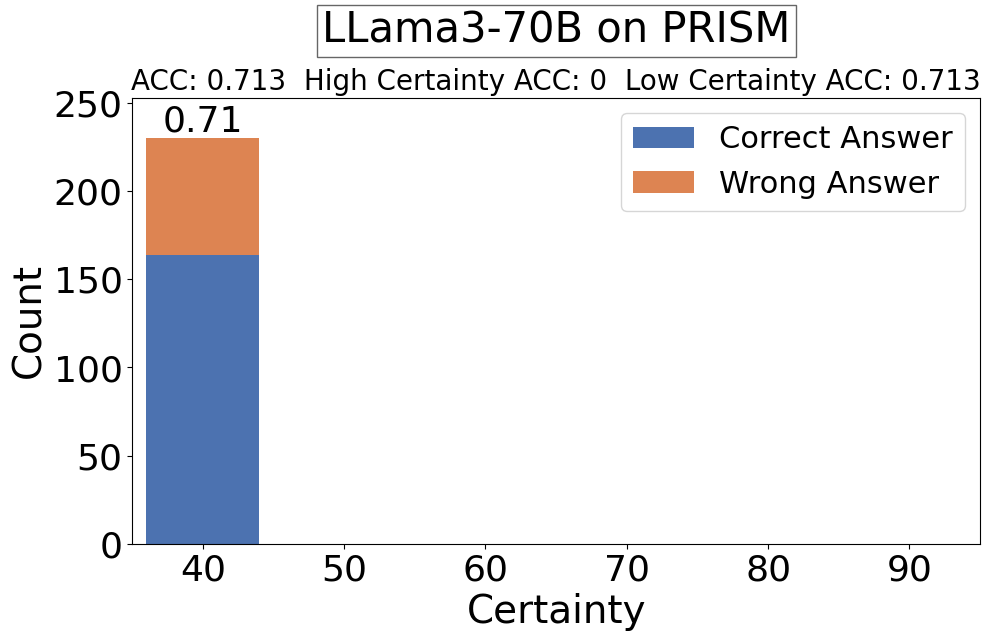

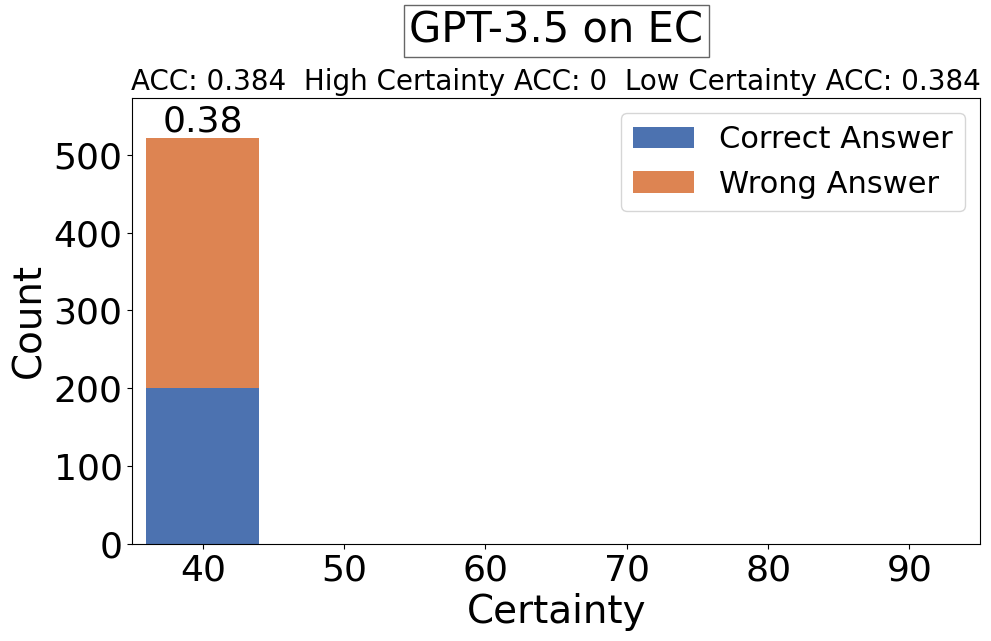

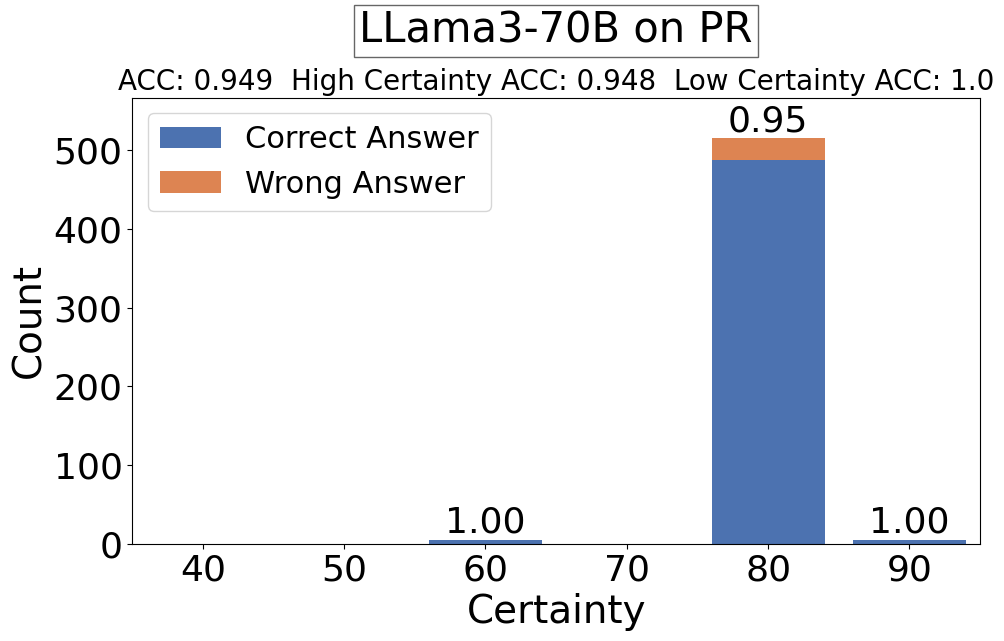

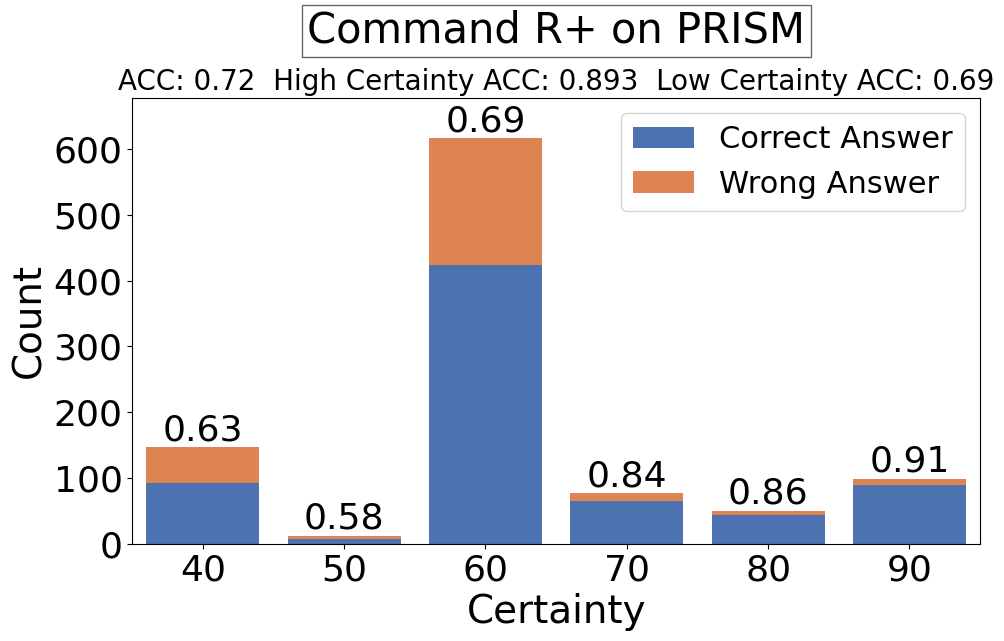

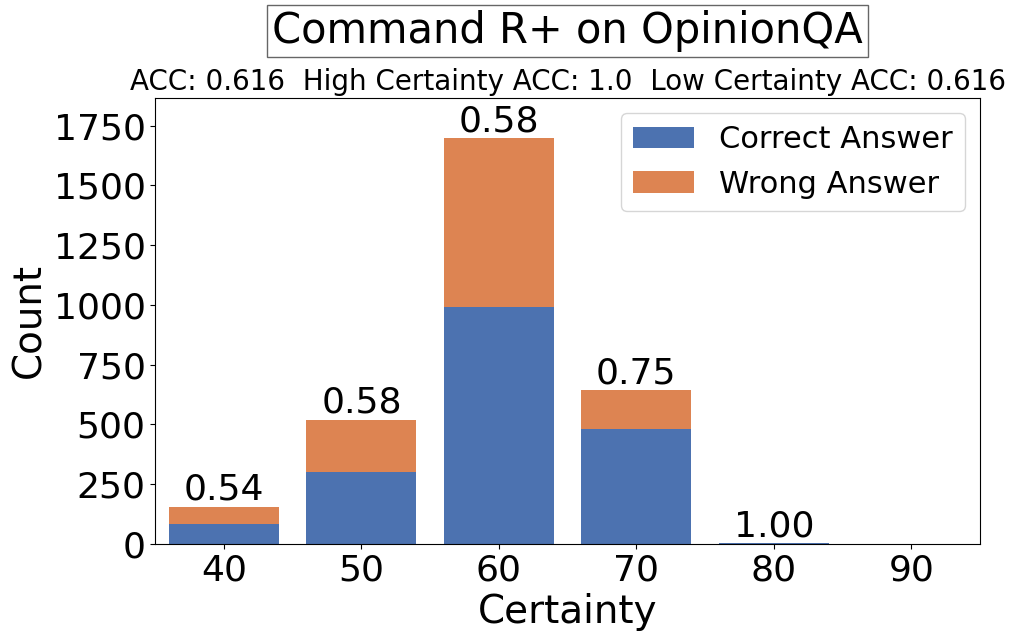

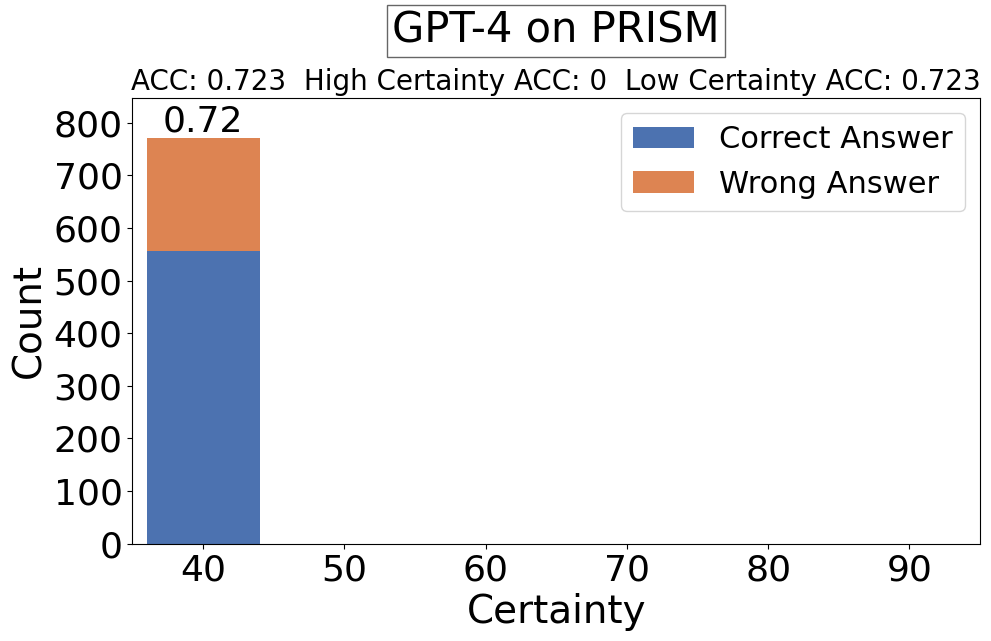

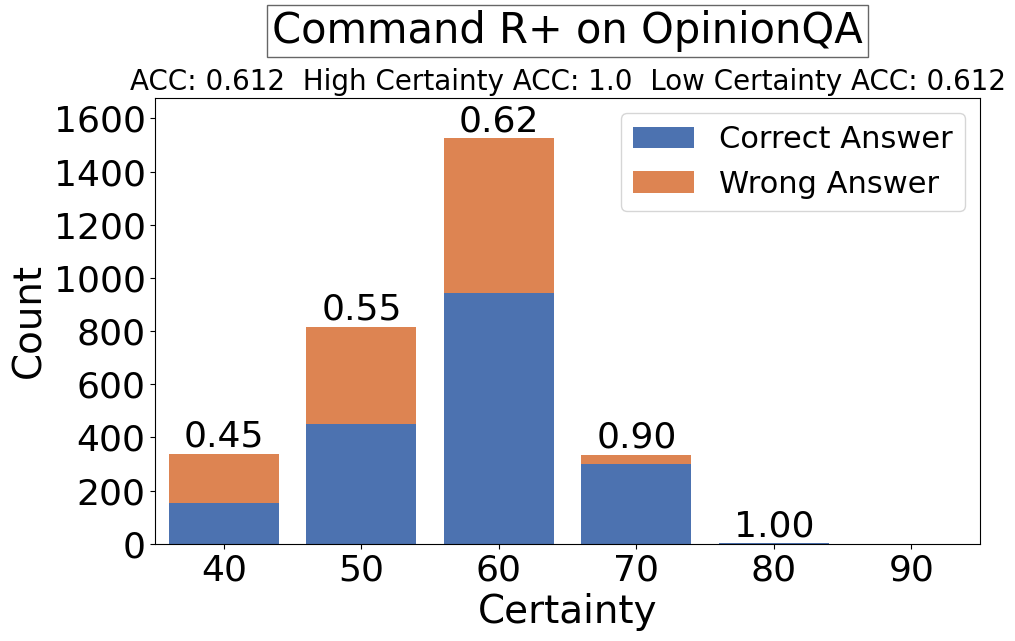

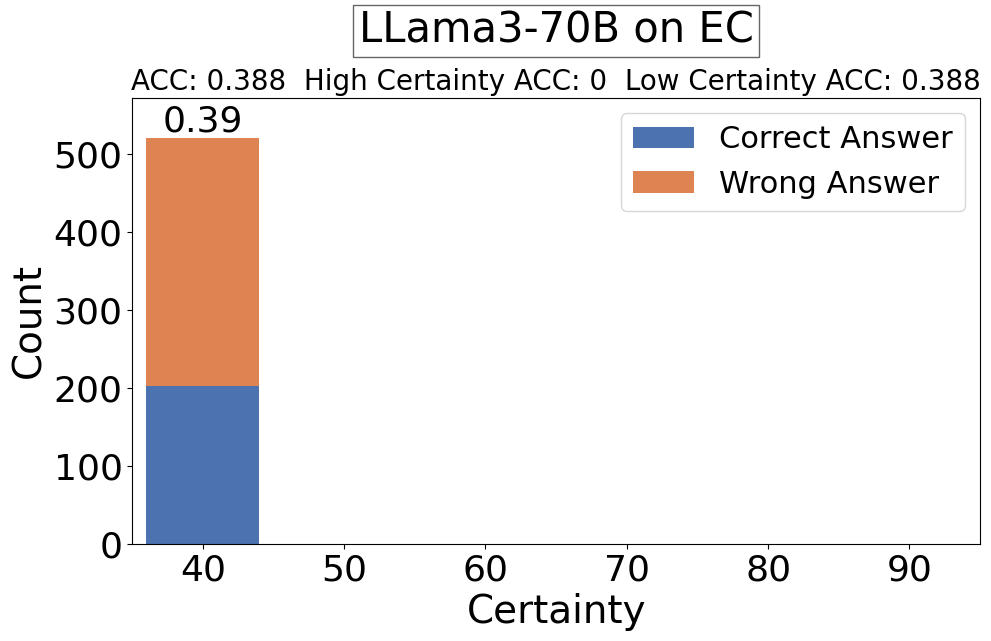

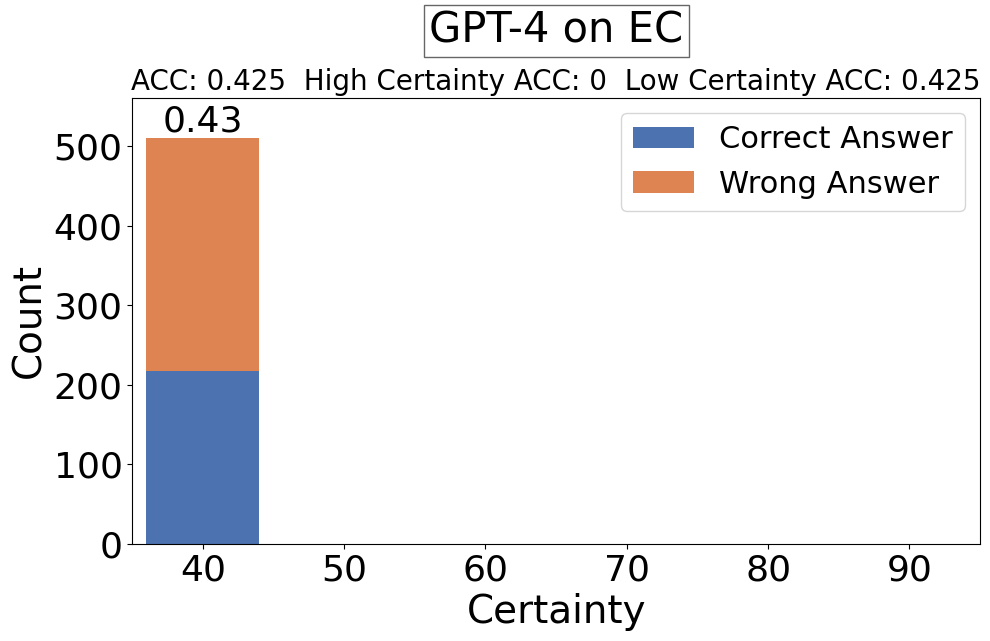

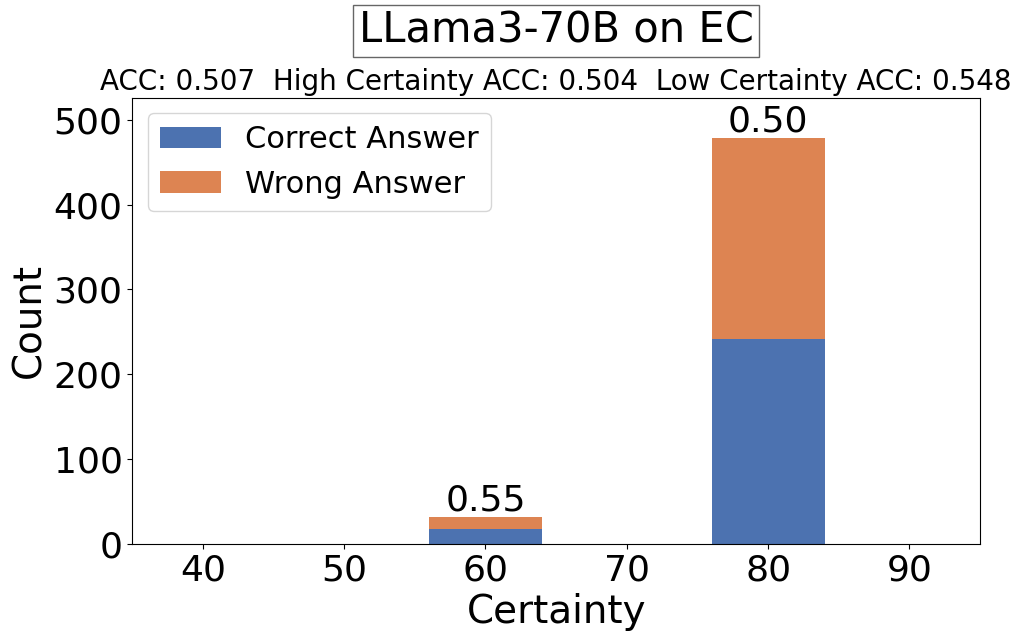

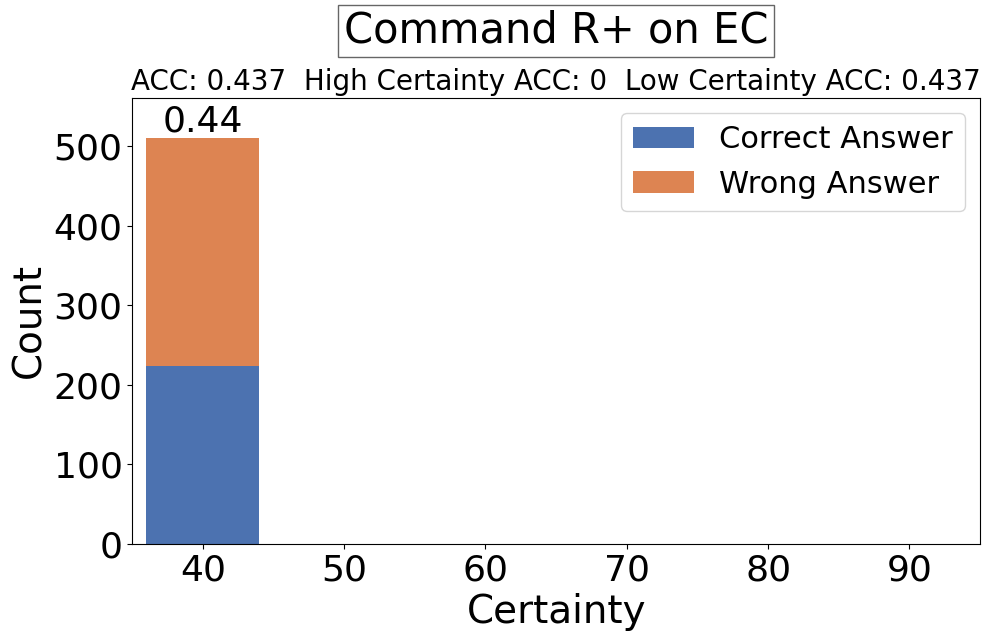

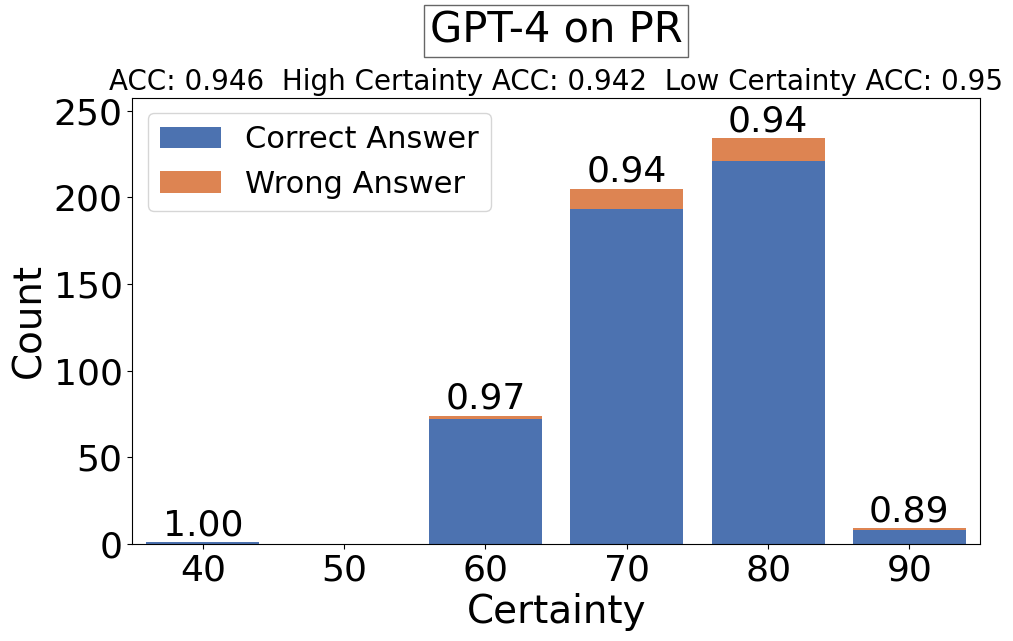

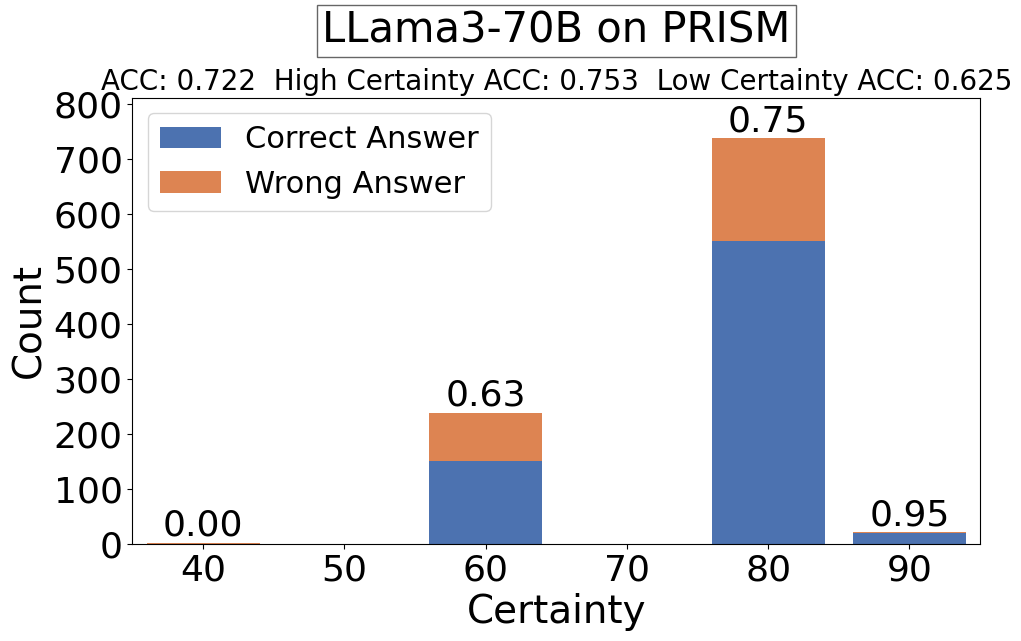

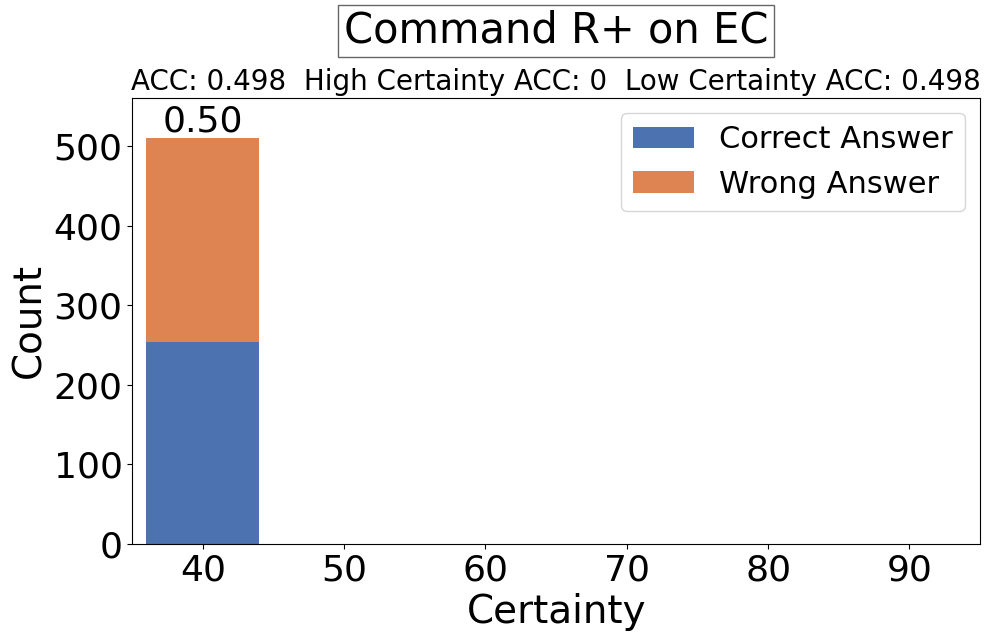

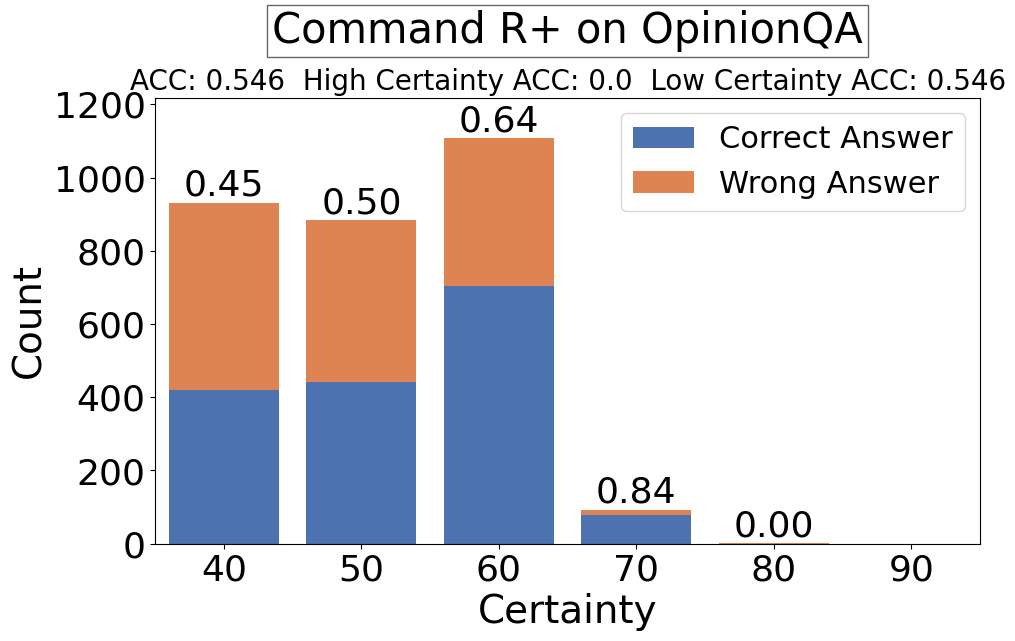

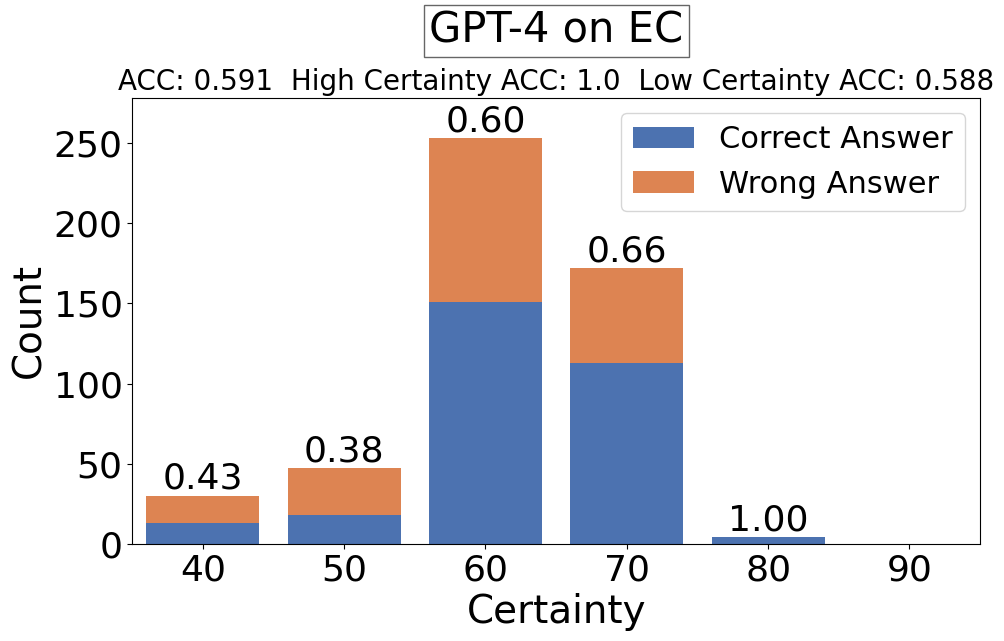

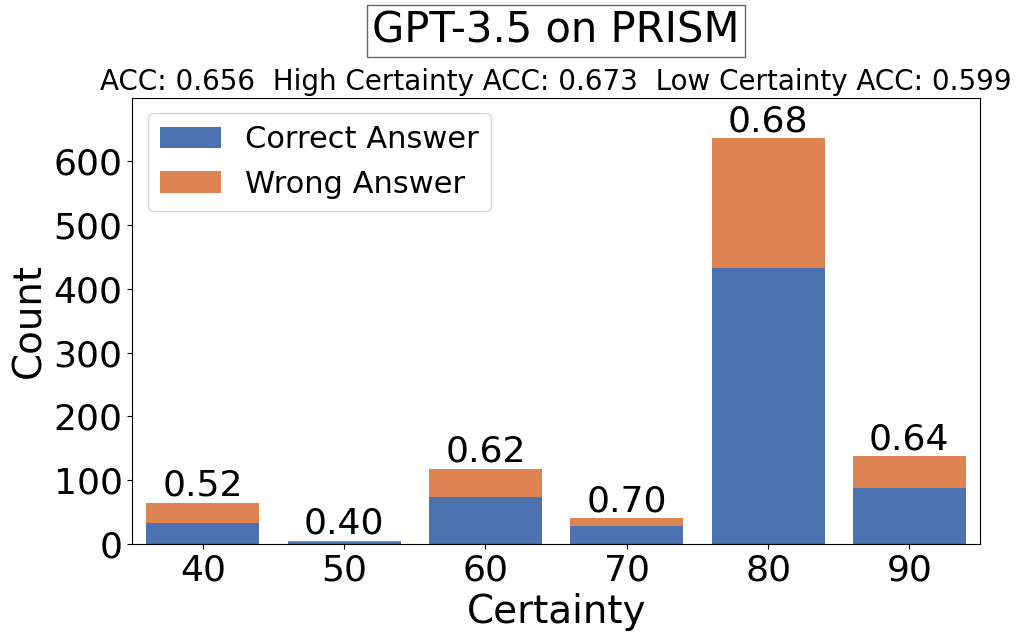

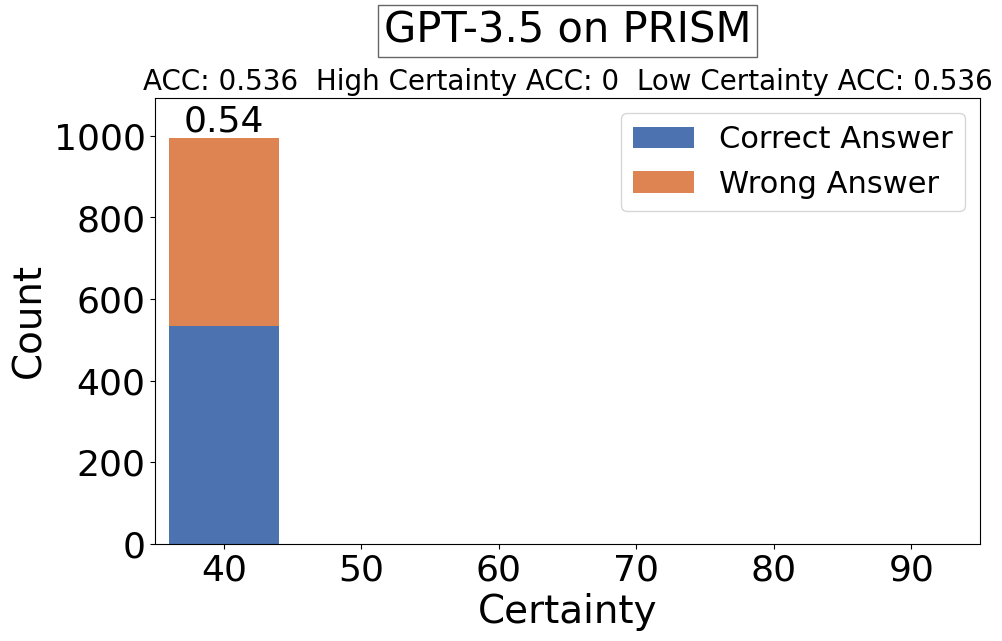

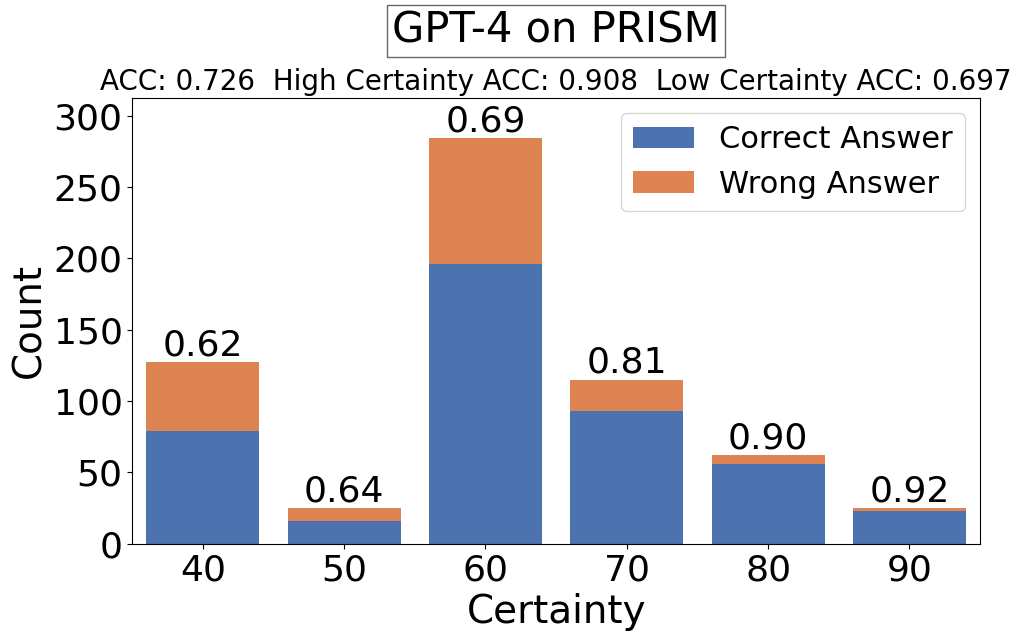

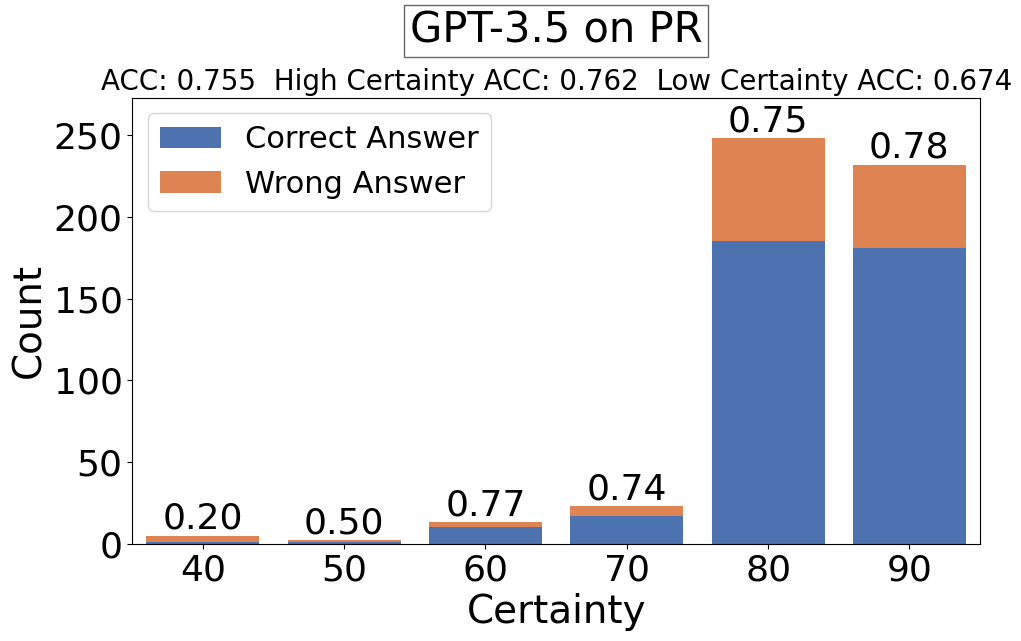

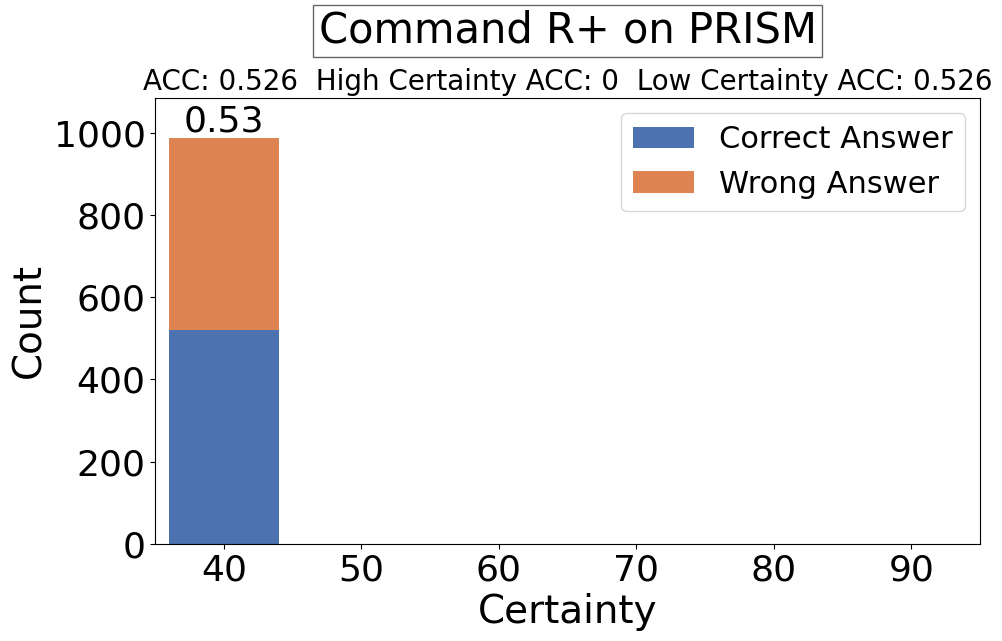

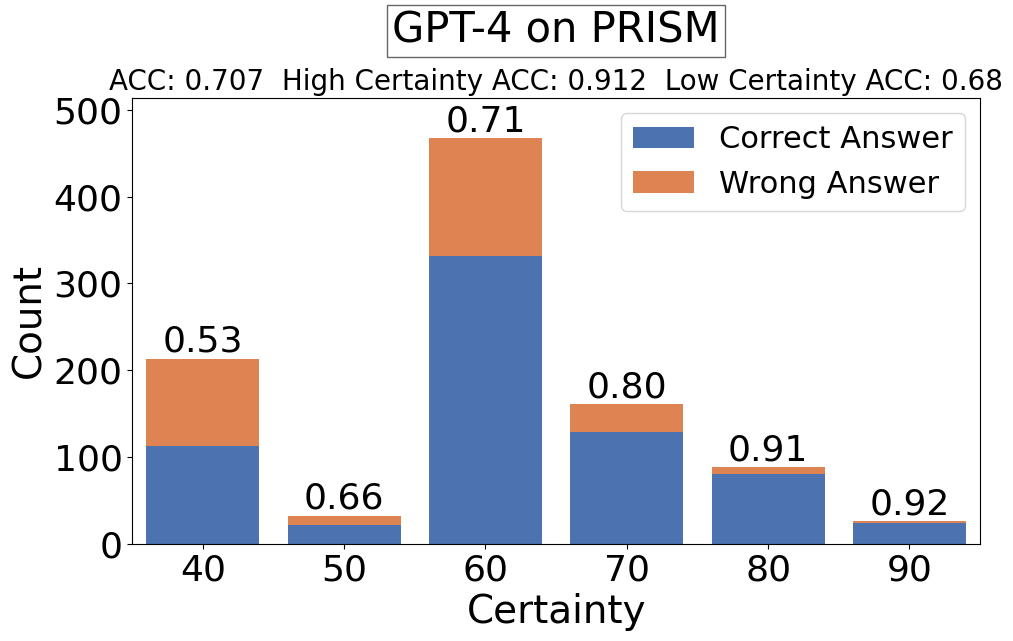

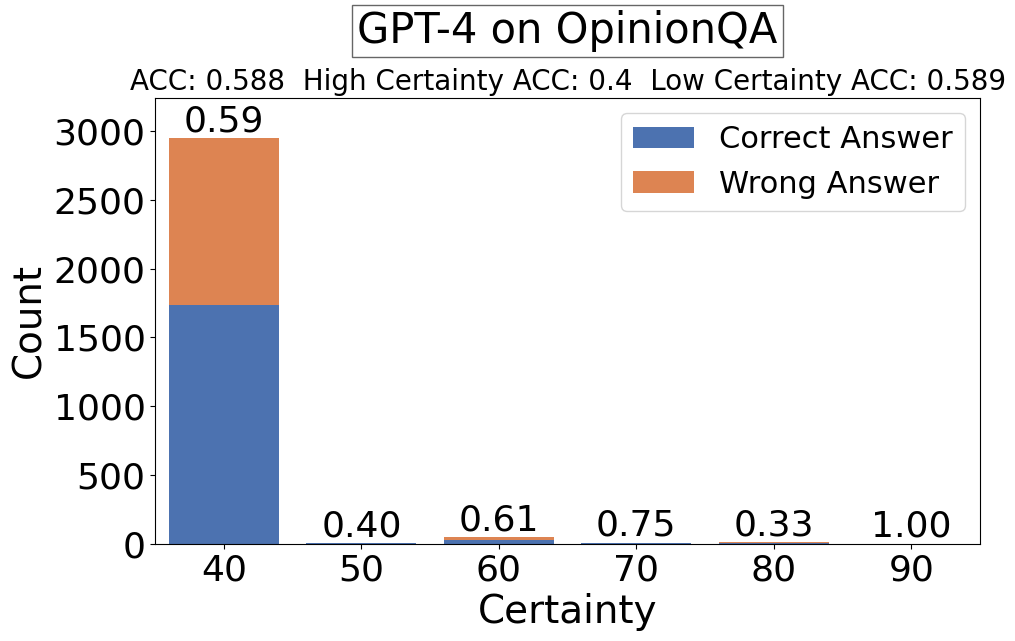

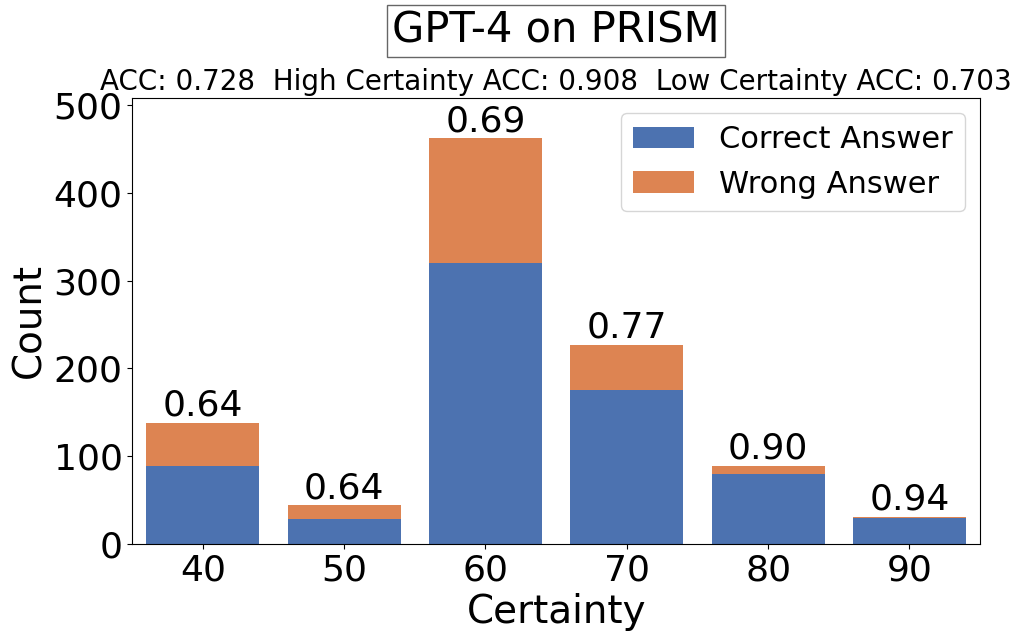

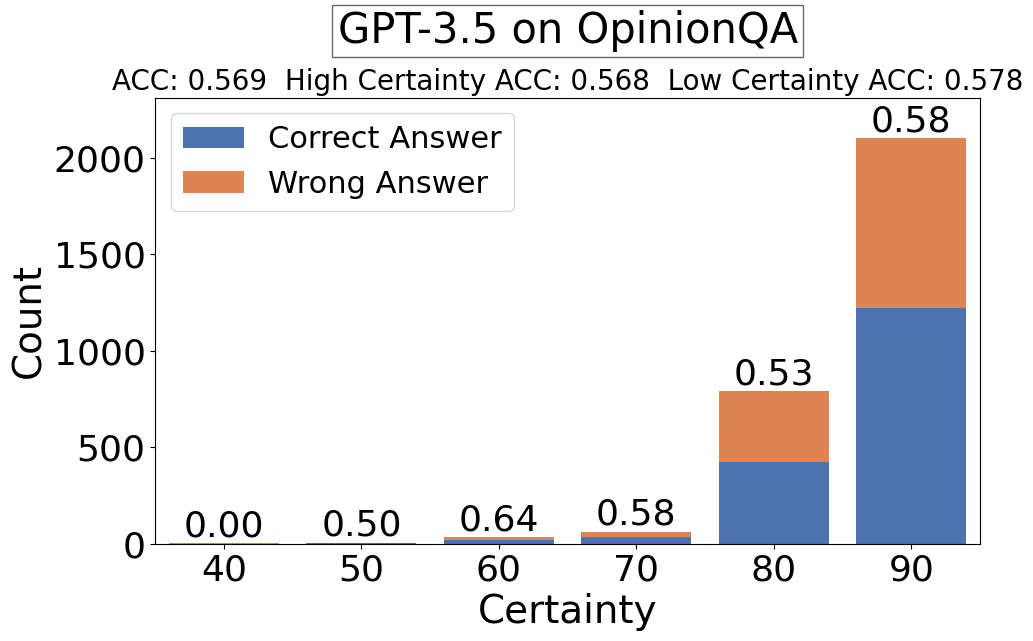

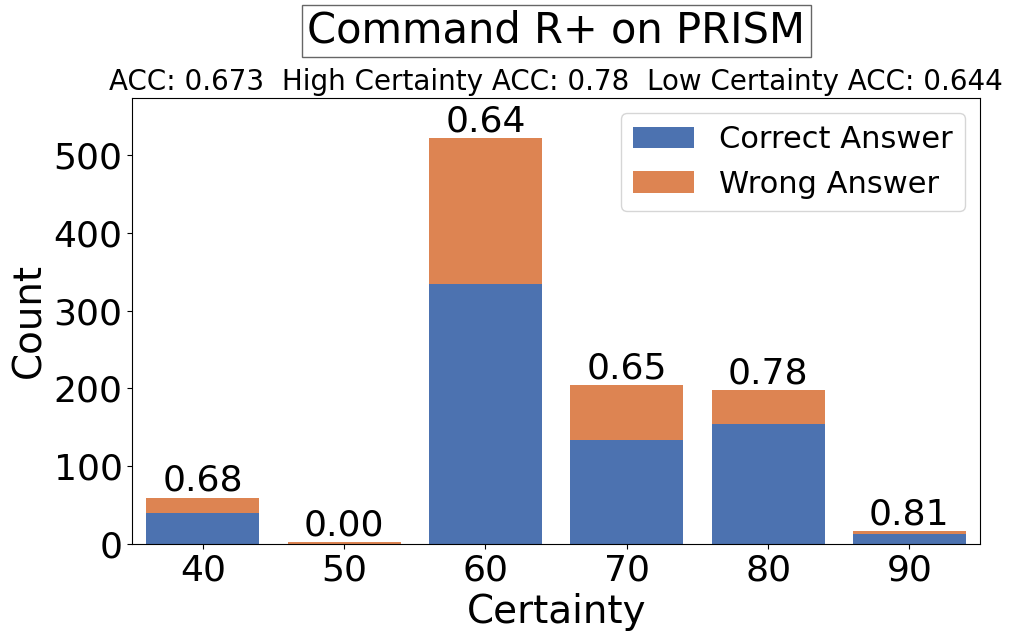

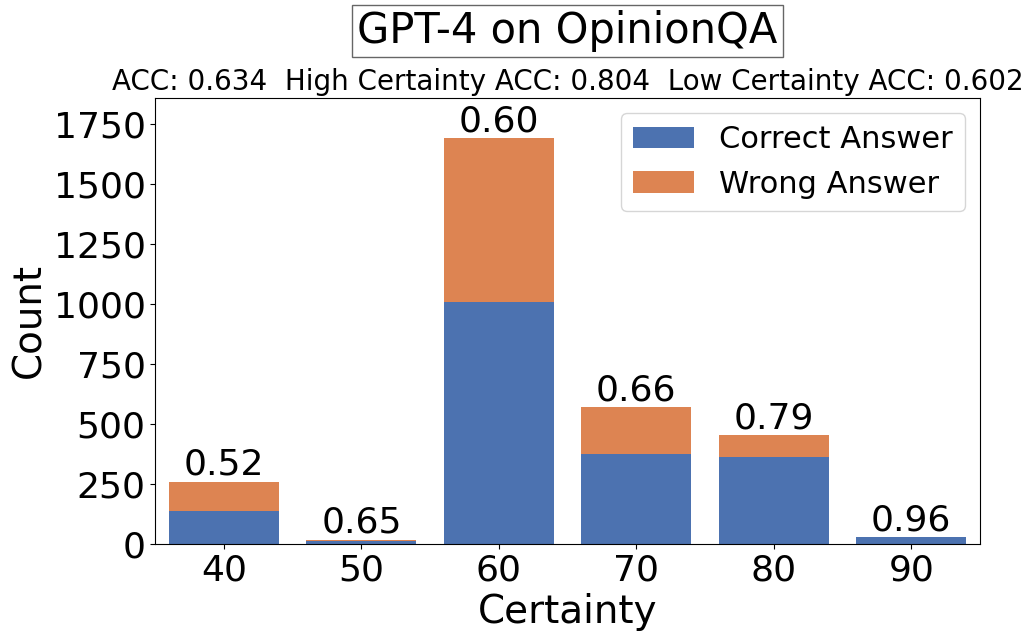

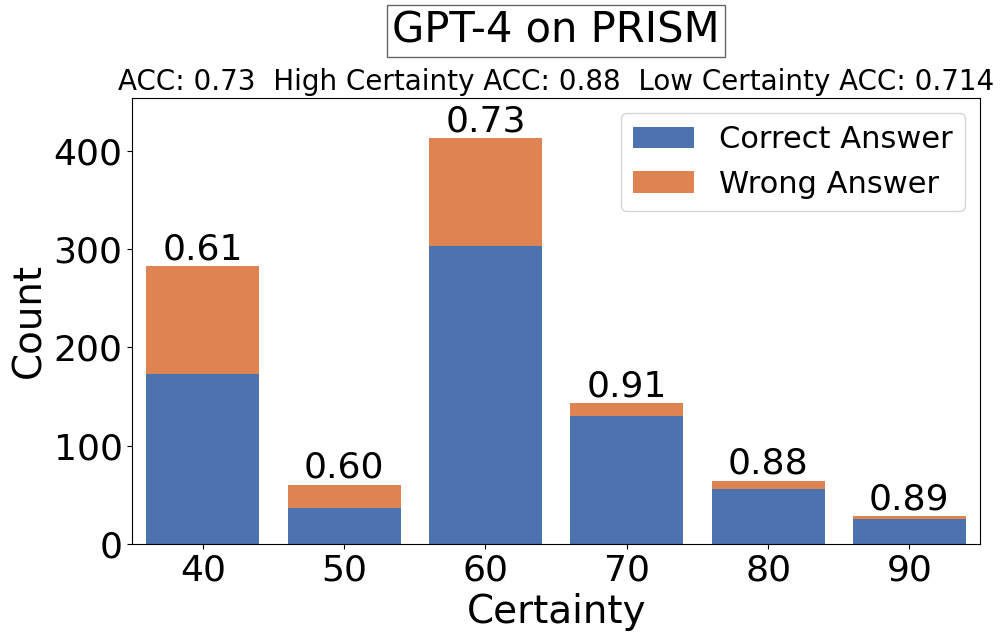

In [94]:
for file in os.listdir("outputs"):
    if file.endswith(".jsonl"):
        jsonl_path = os.path.join("outputs", file)
        draw_certainty_plot(jsonl_path)